## Import and Functions

In [1]:
#import os
import gc
import sys
import pickle
#import random
import numpy as np
#import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#import tensorflow as tf
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
%matplotlib inline

In [2]:
def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Random Seeds and Data Import

In [3]:
# Set a seed value: 
keras.utils.set_random_seed(5)

In [4]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"]
    train_x_data     = var["train_x_data"][:]
    train_y_data     = var["train_y_data"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    test_y_sorted    = var["test_y_sorted"][:]
    freq             = var["freq"][:]

## Building Model

In [5]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
#model.summary()

2022-06-24 12:17:05.356041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-24 12:17:05.356058: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 12:17:05.356075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-24 12:17:05.356566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training algorithm

In [6]:
model.compile(loss = keras.losses.mean_absolute_percentage_error,#lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .0015), 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [7]:
step_num = 12800#int(len(train_y_data)//32)
history = model.fit(
    x=train_x_data[:], y=train_y_data[:], epochs=20, batch_size=32, steps_per_epoch=step_num,
    validation_split=.1, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

Epoch 1/20
12800/12800 - 17s - loss: 4.0589 - mean_absolute_percentage_error: 4.0589 - val_loss: 2.0593 - val_mean_absolute_percentage_error: 2.0593 - 17s/epoch - 1ms/step
Epoch 2/20
12800/12800 - 16s - loss: 1.8596 - mean_absolute_percentage_error: 1.8596 - val_loss: 1.5762 - val_mean_absolute_percentage_error: 1.5762 - 16s/epoch - 1ms/step
Epoch 3/20
12800/12800 - 16s - loss: 1.4917 - mean_absolute_percentage_error: 1.4917 - val_loss: 1.3890 - val_mean_absolute_percentage_error: 1.3890 - 16s/epoch - 1ms/step
Epoch 4/20
12800/12800 - 17s - loss: 1.3057 - mean_absolute_percentage_error: 1.3057 - val_loss: 1.4021 - val_mean_absolute_percentage_error: 1.4021 - 17s/epoch - 1ms/step
Epoch 5/20
12800/12800 - 17s - loss: 1.2209 - mean_absolute_percentage_error: 1.2209 - val_loss: 1.1972 - val_mean_absolute_percentage_error: 1.1972 - 17s/epoch - 1ms/step
Epoch 6/20
12800/12800 - 17s - loss: 1.1680 - mean_absolute_percentage_error: 1.1680 - val_loss: 1.1589 - val_mean_absolute_percentage_error

## Testing Model

In [8]:
perf = model.evaluate(test_x_sorted, test_y_sorted)

1581/1581 [==============================] - 1s 837us/step - loss: 0.9395 - mean_absolute_percentage_error: 0.9395


In [9]:
pred_y = model.predict(test_x_sorted)

1581/1581 [==============================] - 1s 713us/step


In [10]:
denorm_test = denorm(test_y_sorted, max_y)
denorm_pred = denorm(pred_y, max_y)[:,0]
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))
lst2 = list(map(lambda i: (denorm_pred[i]-denorm_test[i])**2,
               range(len(pred_y))))
lst3 = list(map(lambda i: (denorm_pred[i]-denorm_test[i]),
               range(len(pred_y))))
error = np.sqrt(sum(lst2)/len(lst2))
print(f"Each predicted value has an error of ±{np.mean(lst)/np.sqrt(len(lst))}% or ±{error} kHz")
print(f"The average predicted value is {np.mean(denorm_pred)}")
print(f"Predicted first value: {denorm_pred[0]} ±{error} kHz")
pd.DataFrame(denorm_pred).describe()

Each predicted value has an error of ±4.177706325923662e-05% or ±0.4939827273532616 kHz
The average predicted value is 25.33702850341797
Predicted first value: 15.143699645996094 ±0.4939827273532616 kHz


,0
count,50573.000000
mean,25.337029
std,9.142189
min,12.270255
25%,18.499884
50%,21.328650
75%,31.741518
max,83.488045


In [12]:
data_dic = {}
data_dic["Pred_y"] = denorm_pred
data_dic["Act_y"]  = denorm_test
data_dic["x"]      = test_x_sorted
data_dic["res"]    = lst3
with open("data/pickle/error_dist", 'wb') as file:
    pickle.dump(data_dic, file=file)

In [12]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                          _iii:  523.0 B
                           _i9:  523.0 B
                           _i7:  366.0 B
                           _i2:  355.0 B
                            _i:  354.0 B
                          _i11:  354.0 B
                           _i4:  317.0 B
                           _i5:  317.0 B
                           _i3:  308.0 B
                           _i6:  292.0 B


## Ploting Figures

In [13]:
plot_figs = False

In [14]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.title("Validation Performance after each epoch - MAPE")
    plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
    plt.axhline(perf[1], color='g', label="Average Error during Testing")
    plt.xlabel("Epoch (80% of total training data)")
    plt.ylabel("Average Percent Error (%)")
    plt.legend()
    plt.savefig("plots/validation_performance_over_time_mape.png", dpi=500)

In [15]:
if plot_figs:
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN after trainning to match NASA's NN June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Neural Network(estimated)",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network - MAPE",linewidth=2)
    ax0.set_title("Predicted vs Estimated Plasma Frequency")
    ax0.set_xlabel("Epoch Time (s)")
    ax0.set_ylabel("Plasma Frequency (kHz)")
    ax0.legend()

    res = np.subtract(denorm(pred_y, max_y)[:,0],denorm(test_y_sorted, max_y))
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_NN")
    denorm_test = denorm(test_y_sorted, max_y)
    for i in range(len(res)):
        if denorm_test[i] < 10:
            ax1.scatter(test_time_sorted[i], res[i], s=3, color='r')

    ax1.set_title("Difference between CNN and NN")
    ax1.set_xlabel("Epoch Time (s)")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    fig.savefig("plots/performance_on_test_dataset_mape.png", dpi=500)

In [16]:
def norm_dist(val, mean=np.mean(lst3), standard_dev=np.std(lst3)):
    factor = 1/np.sqrt(2*np.pi*(standard_dev**2))
    exp = np.exp(-(val - mean)**2/(2*(standard_dev**2)))
    return factor*exp

x = [-2 + i*.1 for i in range(40)]
y = [norm_dist(v)*3000 for v in x]

In [17]:
if plot_figs:
    fig, ax = plt.subplots(facecolor='w')
    ax.hist(lst3, 2000, histtype='bar')
    ax.set_xlim(-3,3)
    ax.set_title("Histogram of residual distribution - MAPE")
    ax.set_xlabel("Residual (kHz)")
    ax.set_ylabel("Number of Occurences")
    ax.plot(x,y)
    plt.savefig("plots/hist_mape.png", dpi=500)

In [18]:
# Finding all outliers with a frequency error greater than 5
data_zip = list(filter(lambda x: abs(x[4])>10, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_outliers, test_x_sorted_outliers, test_y_sorted_outliers, pred_y_outliers, res_outliers = list(zip(*data_zip))

NameError: name 'res' is not defined

In [ ]:
data_zip2 = list(filter(lambda x: abs(x[4])<.00003, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_best, test_x_sorted_best, test_y_sorted_best, pred_y_best, res_best = list(zip(*data_zip2))

In [ ]:
if plot_figs:
    n = len(res_outliers)
    #plt.figure(figsize=(15, 4*n))
    fig, ax = plt.subplots(nrows=n, figsize=(9, 3*n), facecolor='w', dpi=200)

    for i in range(0, n):    
        ax[i].set_ylabel("V^2/Hz")
        ax[i].set_xlabel("Frequency (kHz)")
        ax[i].xaxis.set_label_coords(.5, -.04)
        ax[i].scatter(freq/1000, denorm(test_x_sorted_outliers[i], max_y), s=6,label='WIND data')
        ax[i].plot(freq/1000, denorm(test_x_sorted_outliers[i], max_y), markersize=1,label='WIND data')

        ax[i].axvline(x=denorm(pred_y_outliers, max_y)[i], color='r', label="CNN")
        ax[i].axvline(x=denorm(test_y_sorted_outliers, max_y)[i], color='g', label="NASA estimate")
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1, 550)
        ax[i].set_xlim(3.5, 275)
        ax[i].set_aspect(.2)
        ax[i].text(4, 300, f"Plot #{i+1} - Residual: {np.round(res_outliers[i],2)}")
        ax[i].legend()

    fig.suptitle("The plot of the spectra with CNN and NASA estimate for plasma frequency", y=0.888)
    plt.savefig("plots/outliers.png", dpi=fig.dpi, bbox_inches='tight')


In [ ]:
if plot_figs:
    plt.figure(facecolor='w',figsize=(5,5), dpi=500)
    plt.scatter(denorm_pred, denorm_test, s=.1)
    plt.xlabel("CNN Predicted Plasma Frequency")
    plt.ylabel("NASA's NN Predicted Plasma Frequency")
    plt.savefig("plots/plot_opposing_predictions.png")

In [ ]:
if plot_figs:
    plt.figure(figsize=(8,8), facecolor='w')
    plt.hist2d(denorm_pred, denorm_test, bins =[100, 100], density=True,cmap = plt.cm.Greys)
    plt.colorbar()
    plt.savefig("plots/2dhist3.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of NASA's NN Plasma Frequency Predictions")
    plt.hist(denorm_test, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    plt.savefig("plots/hist_nasa_nn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of CNN Plasma Frequency Predictions")
    plt.hist(denorm_pred, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    plt.savefig("plots/hist_cnn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.scatter(denorm_test, lst3, s=1)
    plt.axhline(0, color='r', linewidth=.5)
    plt.xlabel("NASA Predicted Plasma Frequency (kHz)")
    plt.ylabel("Residuals (kHz)")
    plt.title("Comparing change in residuals for each respective plasma frequency")
    plt.savefig("plots/residual_and_nasa_plasma_freq", dpi=500)
    plt.show()

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.hist2d(denorm_test, lst3, bins=[100,100])
    plt.xlabel("NASA's NN Plasma Frequency (kHz)")
    plt.ylabel("Residuals")
    plt.colorbar()
    plt.savefig("plots/resvsfp1.png")

## Continous Probablity Distribution

In [2]:
with open("data/pickle/error_dist", 'rb') as file:
    data_dic = pickle.load(file=file)
    
denorm_pred = np.array(data_dic["Pred_y"])
denorm_test = np.array(data_dic["Act_y"])

del(data_dic)
gc.collect()

0

In [3]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

NameError: name 'sizeof_fmt' is not defined

In [14]:
maximum_y_val = max(denorm_test)
count_freq_bins = []
for f in range(10, 85):
    count_freq_bins.append(len(np.where(abs(np.subtract(denorm_test,f+.5))<.5)[0]))
max_bin = max(count_freq_bins)
print(maximum_y_val)

85.33331298828125


In [3]:

maximum_y_val = max(denorm_test)
diff = 1
denorm_pred_np = np.array(denorm_pred)
indices_count = [0 for _ in range(int(maximum_y_val))]

for f in denorm_test:
    indices = np.where(np.abs(denorm_pred_np-f)<diff)[0]
    indices_count[int(f-1)] += len(indices)
    
print(indices_count)
print("done")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 259617, 5131726, 10466110, 3037000, 3582172, 13956140, 62921526, 36203285, 39754450, 14025925, 6281197, 996033, 925157, 1000715, 1233476, 1045155, 1991817, 4526121, 7138438, 7305686, 3037482, 1361801, 3079230, 2497478, 6473725, 2676195, 1702002, 1322199, 694681, 518478, 486097, 235793, 134541, 59204, 7136, 4567, 2514, 4432, 8390, 26894, 7703, 11986, 5043, 206, 65, 510, 247, 89, 77, 80, 389, 48, 128, 104, 35, 47, 80, 119, 64, 121, 39, 40, 79, 21, 7, 8, 36, 87, 0, 36, 15, 149, 54, 0]
done


In [4]:
max(indices_count)

62921526

In [10]:

x = []
y = []
diff = 1
count = 0

for f in denorm_test:
    indices = np.where(np.abs(denorm_pred-f)<diff)[0]
    #scaling = int(max(indices_count)/indices_count[int(f-1)])
    x.extend(np.array(f).repeat(len(indices)))
    y.extend(np.subtract(denorm_pred[indices],f))
    
    if count%5000 == 0:
        print(count, len(y), len(y))
        #if len(indices) != 1:
        #    print(len(indices))

    count += 1
    
print(count, len(y), len(y))

print("done")
del(indices)
gc.collect()

0 3703 3703
5000 27196352 27196352
10000 72254083 72254083
15000 96962610 96962610
20000 110346032 110346032
25000 144181896 144181896
30000 159157022 159157022
35000 171001026 171001026
40000 195148709 195148709
45000 221883797 221883797
50000 240760158 240760158
50573 246142297 246142297
done


8

In [ ]:
del(denorm_pred)
del(denorm_test)
gc.collect()

### def gen():
    x = []
    y = []
    diff = 1
    count = 0
    denorm_pred_np = np.array(denorm_pred)

    for f in denorm_test:
        indices = np.where(np.abs(denorm_pred_np-f)<diff)[0]
        #scaling = int(max(indices_count)/indices_count[int(f-1)])
        x.extend(np.array(f).repeat(len(indices)))
        y.extend(np.subtract(denorm_pred_np[indices],f))

        if count%5000 == 0:
            print(count, len(y), len(y))
            #if len(indices) != 1:
            #    print(len(indices))

        count += 1

    print(count, len(y), len(y))

print("done")

In [ ]:
hist2dlist = np.array([np.array([0 for _ in range(100)]) for _ in range(85)])
print("start")
for i in range(len(x)):
    print("1")

    # count up the x and y coords 
    hist2dlist[int(x[i]), int((y[i]+1)*100/2)] += 1
    if i%1000==0:
        print(i)

In [30]:
diff = 1
count = 0

hist2dlist = np.array([np.array([0 for _ in range(100)]) for _ in range(85)])

print("Started")
for f in denorm_test:
    indices = np.where(np.abs(denorm_pred-f)<diff)[0]

    x = int(f)
    y_list = np.multiply(np.add(denorm_pred[indices],1-f), 100/2)
    
    for y in y_list:
        # count up the x and y coords 
        hist2dlist[x, int(y)] += 1
    if count%5000==0:
        print(count)
    count += 1
    


Started
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [41]:
hist2dlist2 = np.transpose(hist2dlist2)

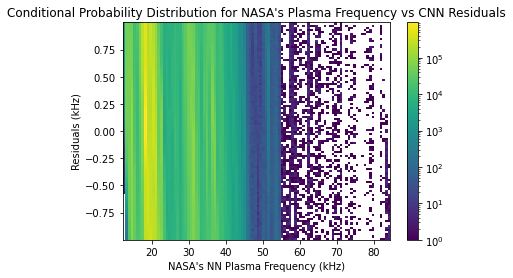

In [8]:
plt.figure(facecolor='w')
plt.hist2d(x, y, bins=[85,100], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.title("Conditional Probability Distribution for NASA's Plasma Frequency vs CNN Residuals")
plt.xlabel("NASA's NN Plasma Frequency (kHz)")
plt.ylabel("Residuals (kHz)")
plt.savefig("plots/conditional_probability_distribution.png")
plt.show()

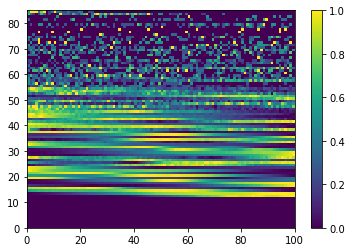

In [52]:
plt.pcolormesh(hist2dlist2)
plt.colorbar()

In [16]:
np.shape(hist2dlist)

(85, 100)

In [50]:
hist2dlist2 = [row[:] for row in hist2dlist]

for i in range(len(hist2dlist2)):
    min_val = min(hist2dlist2[i])
    range_val = max(*hist2dlist2[i], 1) - min(hist2dlist2[i])
    hist2dlist2[i] = np.divide(np.subtract(hist2dlist2[i], min_val), range_val)
    
    #hist2dlist2[i] = [(v if v>0 else 1e-9) for v in hist2dlist2[i]]

In [51]:
print(hist2dlist2)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0

## Pickle Stuff

In [4]:
with open("data/pickle/conditional_probx", 'rb') as file:
    x = pickle.load(file=file)
    
with open("data/pickle/conditional_proby", 'rb') as file:
    y = pickle.load(file=file)

EOFError: Ran out of input

In [4]:
with open("data/pickle/conditional_probx", 'wb') as file:
    pickle.dump(x, file=file)

In [ ]:
with open("data/pickle/conditional_proby", 'wb') as file:
    pickle.dump(y, file=file)